In [1]:
#!/usr/bin/env python

import pandas as pd
import os
import numpy as np
import sys

sys.path.append('./..')
sys.path.append('./../..')
import glob
import yaml
import pickle
from collections import Counter
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel

pandarallel.initialize()
try:
    from . import utils_createAnomalies as utils
except:
    import utils_createAnomalies as utils

# --------------------------------------------------------------------- #

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
CONFIG_FILE = './../config_preprocessor_v02.yaml'
id_col = 'PanjivaRecordID'
save_dir = None
CONFIG = None
DIR = None
DATA_DIR = None

In [3]:
def set_up_config(_DIR):
    global CONFIG_FILE
    global DIR
    global save_dir
    global CONFIG
    global DATA_DIR

    with open(CONFIG_FILE) as f:
        CONFIG = yaml.safe_load(f)
    if _DIR is None:
        DIR = CONFIG['DIR']

    save_dir = os.path.join(
        './..',
        CONFIG['save_dir'],
        DIR
    )
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    DATA_DIR = save_dir
    return


set_up_config(DIR)

In [4]:
def get_data():
    global id_col
    global DATA_DIR
    f_name_train = 'train_data.csv'
    f_name_test = 'test_data.csv'

    df_train = pd.read_csv(os.path.join(DATA_DIR, f_name_train), index_col=None)
    df_test = pd.read_csv(os.path.join(DATA_DIR, f_name_test), index_col=None)

    domain_dims = None
    with open(os.path.join(DATA_DIR, 'domain_dims.pkl'), 'rb') as fh:
        domain_dims = pickle.load(fh)

    # -------------------
    # Sort the columns
    # -------------------
    cols = list(df_train.columns)
    cols.remove((id_col))
    cols = [id_col] + list(sorted(cols))

    df_train = df_train[cols]
    df_test = df_test[cols]

    return df_train, df_test, domain_dims


# -------------------------------------------------------- #

df_train, df_test, domain_dims = get_data()
columnWise_coOccMatrix_dict = utils.get_coOccMatrix_dict(df_train, id_col='PanjivaRecordID')
domains = list(df_train.columns)

Col 1 & 2 Carrier ConsigneePanjivaID (701, 8960) >> (701, 8960)
Col 1 & 2 Carrier HSCode (701, 97) >> (701, 97)
Col 1 & 2 Carrier PortOfLading (701, 286) >> (701, 286)
Col 1 & 2 Carrier PortOfUnlading (701, 75) >> (701, 75)
Col 1 & 2 Carrier ShipmentDestination (701, 136) >> (701, 136)
Col 1 & 2 Carrier ShipmentOrigin (701, 126) >> (701, 126)
Col 1 & 2 Carrier ShipperPanjivaID (701, 10661) >> (701, 10661)
Col 1 & 2 ConsigneePanjivaID HSCode (8960, 97) >> (8960, 97)
Col 1 & 2 ConsigneePanjivaID PortOfLading (8960, 286) >> (8960, 286)
Col 1 & 2 ConsigneePanjivaID PortOfUnlading (8960, 75) >> (8960, 75)
Col 1 & 2 ConsigneePanjivaID ShipmentDestination (8960, 136) >> (8960, 136)
Col 1 & 2 ConsigneePanjivaID ShipmentOrigin (8960, 126) >> (8960, 126)
Col 1 & 2 ConsigneePanjivaID ShipperPanjivaID (8960, 10661) >> (8960, 10661)
Col 1 & 2 HSCode PortOfLading (97, 286) >> (97, 286)
Col 1 & 2 HSCode PortOfUnlading (97, 75) >> (97, 75)
Col 1 & 2 HSCode ShipmentDestination (97, 136) >> (97, 136)
Co

In [5]:
kk = df_train.groupby(['PortOfLading', 'PortOfUnlading', ]).size().reset_index(name='count')

# ==================
# Select pairs such that their count in (20,80) percentile
# ==================

lb = np.percentile(list(kk['count']), 20)
ub = np.percentile(list(kk['count']), 80)
kk_1 = kk.loc[(kk['count'] >= lb) & (kk['count'] <= ub)]
kk_2 = kk_1.sample(frac=0.20)
kk_2 = kk_2.reset_index(drop=True)
del kk_2['count']

In [64]:
target_PortOfLading_PortOfUnlading = kk_2


In [65]:
target_PortOfLading_PortOfUnlading

,PortOfLading,PortOfUnlading
0,214,31
1,200,45
2,114,18
3,110,45
4,133,14
...,...,...
210,152,64
211,264,45
212,37,23
213,34,23


In [66]:
 

# ===============
# We need list of comapnies trading in these routes
# ===============
pp = df_train.merge(
    target_PortOfLading_PortOfUnlading,
    on=['PortOfLading', 'PortOfUnlading'],
    how='inner'
)

candidate_Shipper = list(set(pp['ShipperPanjivaID']))
_count = int(0.1 * domain_dims['ShipperPanjivaID'])

target_Shipper = np.random.choice(candidate_Shipper, size=_count, replace=False)
print('Number of interesting shippers ', len(target_Shipper))

_count = int(0.1 * domain_dims['ConsigneePanjivaID'])
# ==================================
# Now we have the list of shippers
# Consignee who do business with them are actually suspicous
# ==================================
pp_1 = pp.loc[pp['ShipperPanjivaID'].isin(target_Shipper)]
candidate_Shipper = list(set(pp_1['ConsigneePanjivaID']))
target_Consignee = np.random.choice(candidate_Shipper, size=_count, replace=False)
print('Number of interesting consignee ', len(target_Consignee))

Number of interesting shippers  1066
Number of interesting consignee  896


'''
# ## ---------------------------------------------
# # Criteria 1
# ## We define interesting records as ones which satisfy these 2 conditions:
# ### 1. contains both these comapnies
# ### 2. contains the route ( 'PortOfLading','PortOfUnlading' )
# ## ---------------------------------------------
'''

97


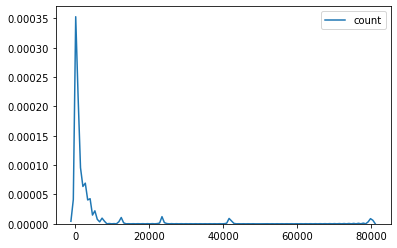

In [15]:
hh = df_train.groupby(['HSCode']).size().reset_index(name='count')
print(len(hh))
sns.kdeplot(hh['count'])
lb = np.percentile(list(hh['count']), 10)
ub = np.percentile(list(hh['count']), 90)
_count = int(0.3 * len(hh))
candidate_HSCode = set(df_train.loc[(df_train['ShipperPanjivaID'].isin(target_Shipper)) & (df_train['ConsigneePanjivaID'].isin(target_Consignee))]['HSCode'])
candidate_HSCode = list(hh.loc[(hh['count']>=lb) & (hh['count']<=ub) & (hh['HSCode']).isin(candidate_HSCodes)]['HSCode'])
target_HSCode = np.random.choice(candidate_HSCode, size=_count, replace=False)


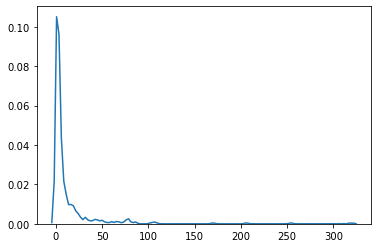

In [16]:
qq = df_train.loc[(df_train['ShipperPanjivaID'].isin(target_Shipper)) | (df_train['ConsigneePanjivaID'].isin(target_Consignee)) ]
qq = qq.loc[qq['HSCode'].isin(target_HSCode)]
qq_1 = qq.groupby(['ShipmentOrigin', 'ShipmentDestination']).size().reset_index(name='count')
sns.kdeplot(list(qq_1['count']))

In [17]:
lb = np.percentile(list(qq_1['count']), 5)
ub = np.percentile(list(qq_1['count']), 95)
_count = int(0.25 * len(qq_1))

target_ShipmentOrigin_ShipmentDestination = qq_1.loc[(qq_1['count'] >= lb) & (qq_1['count'] <= ub)].sample(n=_count)
del target_ShipmentOrigin_ShipmentDestination['count']

In [32]:
target_ShipmentOrigin_ShipmentDestination

,ShipmentOrigin,ShipmentDestination
387,93,72
219,64,131
382,90,100
386,93,57
48,12,74
...,...,...
73,21,27
405,103,87
184,54,72
243,76,25


'''
## --------------------------------------------
#  ------------- Criteria 2 -------------------
## Use the set of consignee and shippers obtained earlier
## We define interesting records as ones which satisfy these 2 conditions:
### 1. contain one of the comapnies OR  contains a target HSCode
### 2. contain the pair (ShipmentOrigin 	ShipmentDestination)
## --------------------------------------------
'''

In [19]:
# =========================================
# select 2 of _perturb domains
# set them to random options :  such that the row does not occur in train
# =========================================

def generate_by_criteria(row, criteria, _fixed, _perturb, co_occurrence_dict, ref_df, id_col='PanjivaRecordID'):
    is_duplicate = True
    trials = 0
    max_trials = 100
    while is_duplicate:
        trials += 1
        p_d = np.random.choice(_perturb, size=2, replace=False)
        new_row = row.copy()
        for _dom in p_d:
            # select reference_domain from _fixed
            _f_d = np.random.choice(_fixed, size=1, replace=False)[0]
            _f_entity = row[_f_d]

            # select entity in _dom such that it does not co-occur with
            _pair = sorted([_dom, _f_d])
            key = '_+_'.join(_pair)

            _matrix = co_occurrence_dict[key]
            if _pair[0] == _f_d:
                vec = _matrix[_f_entity, :]
            else:
                vec = _matrix[:, _f_entity]
            # Select e such that vec[e] == 0
            pool = list(np.where(vec == 0)[0])
            e = np.random.choice(pool, size=1)[0]
            new_row[_dom] = e
            # check for duplicates
        hash_val = utils.get_hash_aux(new_row, id_col)
        is_duplicate = utils.is_duplicate(ref_df, hash_val)

        if trials == max_trials:
            print('Error')
            new_row[_perturb[0]] = None
            break

    suffix = '00' + str(criteria)
    row[id_col] = utils.aux_modify_id(row[id_col], suffix)
    print(criteria, ' :: generated record')
    return row


# --------------------------------------------------------------------- #

hash_ref_df = utils.add_hash(df_train.copy(), id_col)

In [69]:
# ================================================ #
# C1 ::
# target_Shipper
# target_Consignee
# target_PortOfLading_PortOfUnlading
# ================================================ #

a = df_train.merge(
    target_PortOfLading_PortOfUnlading,
    on=['PortOfLading', 'PortOfUnlading'],
    how='inner'
)
try:
    del a['count']
except: 
    pass

a = a.loc[a['ConsigneePanjivaID'].isin(target_Consignee)]
a = a.loc[a['ShipperPanjivaID'].isin(target_Shipper)]

_fixed_set = ['ConsigneePanjivaID', 'PortOfLading', 'PortOfUnlading', 'ShipperPanjivaID']
_perturb_set = [_ for _ in list(domain_dims.keys()) if _ not in _fixed_set]

,PanjivaRecordID,Carrier,ConsigneePanjivaID,HSCode,PortOfLading,PortOfUnlading,ShipmentDestination,ShipmentOrigin,ShipperPanjivaID
0,107316669,367,8157,65,141,29,72,82,501
1,106871422,37,7813,4,141,29,72,103,5111
2,107146731,281,813,51,141,29,72,54,529
3,107519258,367,8157,65,141,29,72,82,501
4,107369234,202,4608,53,141,29,72,83,497
...,...,...,...,...,...,...,...,...,...
4297,112809359,138,3101,51,163,31,96,89,3593
4298,113440416,104,4291,4,173,11,33,48,2195
4299,113440418,104,4291,4,173,11,33,48,2195
4300,113355731,290,2578,57,271,2,57,82,9596


In [71]:
res_criteria_1_1 = a.parallel_apply(
    generate_by_criteria,
    axis=1,
    args=(101, _fixed_set, _perturb_set, columnWise_coOccMatrix_dict, hash_ref_df)
)


101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record
101  :: generated record


In [78]:
res_criteria_1_1

,PanjivaRecordID,Carrier,ConsigneePanjivaID,HSCode,PortOfLading,PortOfUnlading,ShipmentDestination,ShipmentOrigin,ShipperPanjivaID
0,10731666900101,367,8157,65,141,29,72,82,501
1,10687142200101,37,7813,4,141,29,72,103,5111
2,10714673100101,281,813,51,141,29,72,54,529
3,10751925800101,367,8157,65,141,29,72,82,501
4,10736923400101,202,4608,53,141,29,72,83,497
...,...,...,...,...,...,...,...,...,...
4297,11280935900101,138,3101,51,163,31,96,89,3593
4298,11344041600101,104,4291,4,173,11,33,48,2195
4299,11344041800101,104,4291,4,173,11,33,48,2195
4300,11335573100101,290,2578,57,271,2,57,82,9596


In [49]:
# ================================================ #
# C2 :
# target_HSCode
# target_Consignee
# target_Shipper
# target_ShipmentOrigin_ShipmentDestination
# ================================================ #

a = df_train.merge(
    target_ShipmentOrigin_ShipmentDestination,
    on=['ShipmentOrigin','ShipmentDestination'],
    how='inner'
)

a1 = a.loc[(a['ConsigneePanjivaID'].isin(target_Consignee)) | (a['HSCode'].isin(target_HSCode)) ]
_fixed_set = ['ConsigneePanjivaID', 'ShipmentOrigin', 'HSCode', 'ShipmentDestination']
_perturb_set = [_ for _ in list(domain_dims.keys()) if _ not in _fixed_set]

In [50]:
res_criteria_2_1 = a1.apply(
    generate_by_criteria,
    axis=1,
    args=(201, _fixed_set, _perturb_set, columnWise_coOccMatrix_dict, hash_ref_df)
)

201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record
201  :: generated record


In [54]:
res_criteria_2_1

,PanjivaRecordID,Carrier,ConsigneePanjivaID,HSCode,PortOfLading,PortOfUnlading,ShipmentDestination,ShipmentOrigin,ShipperPanjivaID
0,10703916500201,581,7307,44,43,2,103,82,982
1,10703916600201,581,7307,44,43,2,103,82,982
2,10654758200201,581,7307,22,43,2,103,82,8985
3,10703826700201,581,7307,22,103,2,103,82,4001
4,10703916300201,581,7307,22,43,2,103,82,8985
...,...,...,...,...,...,...,...,...,...
31503,11254215000201,487,7285,21,65,11,33,122,7315
31504,11235408300201,36,8255,19,114,18,102,118,894
31505,11127624800201,36,8255,19,141,18,102,118,894
31506,11198637700201,36,8255,19,114,18,102,118,894


In [55]:
a2 = a.loc[a['ShipperPanjivaID'].isin(target_Shipper) | (a['HSCode'].isin(target_HSCode)) ]
_fixed_set = ['ShipmentOrigin', 'HSCode', 'ShipmentDestination', 'ShipperPanjivaID']
_perturb_set = [_ for _ in list(domain_dims.keys()) if _ not in _fixed_set]

In [56]:
res_criteria_2_2 = a2.parallel_apply(
    generate_by_criteria,
    axis=1,
    args=(202, _fixed_set, _perturb_set, columnWise_coOccMatrix_dict, hash_ref_df)
)


202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record
202  :: generated record


In [53]:
res_criteria_2_2

,PanjivaRecordID,Carrier,ConsigneePanjivaID,HSCode,PortOfLading,PortOfUnlading,ShipmentDestination,ShipmentOrigin,ShipperPanjivaID
83,10676732500202,522,4056,34,103,31,103,82,6714
583,11150682800202,522,4056,34,103,31,103,82,6714
1033,10826757000202,202,8842,55,14,43,79,82,7386
1042,10826757100202,202,8842,55,14,43,79,82,7386
1216,10991071100202,202,8842,55,14,43,79,82,7386
...,...,...,...,...,...,...,...,...,...
31479,10971493000202,106,6146,68,92,23,67,37,9653
31480,10873335100202,106,6146,68,92,23,67,37,9653
31481,10912322700202,106,6146,68,92,23,67,37,9653
31482,11171645200202,106,6146,68,92,23,67,37,10383


In [102]:
res_df = pd.DataFrame(columns=list(df_test.columns))
res_df = res_df.append(res_criteria_1_1, ignore_index=True)
res_df = res_df.append(res_criteria_2_1, ignore_index=True)
res_df = res_df.append(res_criteria_2_2, ignore_index=True)
res_df = res_df.dropna()

In [103]:
res_df.drop_duplicates(subset=feature_cols)

,PanjivaRecordID,Carrier,ConsigneePanjivaID,HSCode,PortOfLading,PortOfUnlading,ShipmentDestination,ShipmentOrigin,ShipperPanjivaID
0,10731666900101,367,8157,65,141,29,72,82,501
1,10687142200101,37,7813,4,141,29,72,103,5111
2,10714673100101,281,813,51,141,29,72,54,529
4,10736923400101,202,4608,53,141,29,72,83,497
6,10702695200101,349,2355,89,141,29,72,0,9531
...,...,...,...,...,...,...,...,...,...
19494,10834389400202,352,1769,51,27,45,100,76,791
19496,10879626700202,194,3263,51,60,11,100,76,211
19502,11015166400202,194,3263,51,155,11,100,76,211
19507,11043234800202,194,3263,51,60,11,100,76,6653


In [105]:
res_df.to_csv(
    os.path.join(DATA_DIR, 'anomalies_W_pattern_1.csv'), index=False
)

# ---------------
# Generate non-interesting anomalies ; that do not confiirm to these patterns
# ---------------

In [76]:
rmv_list = list(df_train.merge(target_PortOfLading_PortOfUnlading, how='inner',on =['PortOfLading','PortOfUnlading'])[id_col])
a = df_test.loc[~df_test[id_col].isin(rmv_list)]
a = a.loc[(~a['ConsigneePanjivaID'].isin(target_Consignee)) | (~a['ShipperPanjivaID'].isin(target_Shipper))]
a = a.sample(min(len(a),len(df_test)))

In [79]:
_fixed_set = ['ConsigneePanjivaID', 'PortOfLading', 'PortOfUnlading', 'ShipperPanjivaID']
_perturb_set = [_ for _ in list(domain_dims.keys()) if _ not in _fixed_set]

In [80]:
res_NA_1 = a.parallel_apply(
    generate_by_criteria,
    axis=1,
    args=(901, _fixed_set, _perturb_set, columnWise_coOccMatrix_dict, hash_ref_df)
)


901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record
901  :: generated record


In [ ]:
rmv_list = list(df_train.merge(target_ShipmentOrigin_ShipmentDestination, how = 'inner',on =['ShipmentOrigin','ShipmentDestination'])[id_col])
a = df_test.loc[~df_test[id_col].isin(rmv_list)]
a = a.loc[(~a['ConsigneePanjivaID'].isin(target_Consignee))]
a = a.sample(min(len(a),len(df_test)))
_fixed_set = ['ConsigneePanjivaID', 'ShipmentOrigin','ShipmentDestination']
_perturb_set = [_ for _ in list(domain_dims.keys()) if _ not in _fixed_set]

res_NA_2 = a.parallel_apply(
    generate_by_criteria,
    axis=1,
    args=(902, _fixed_set, _perturb_set, columnWise_coOccMatrix_dict, hash_ref_df)
)


902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record
902  :: generated record


In [94]:
rmv_list = list(df_train.merge(target_ShipmentOrigin_ShipmentDestination, how = 'inner',on =['ShipmentOrigin','ShipmentDestination'])[id_col])
a = df_test.loc[~df_test[id_col].isin(rmv_list)]
a = a.loc[(~a['ShipperPanjivaID'].isin(target_Shipper))]
a = a.sample(min(len(a),len(df_test)))
_fixed_set = [ 'ShipmentOrigin','ShipmentDestination', 'ShipperPanjivaID']
_perturb_set = [_ for _ in list(domain_dims.keys()) if _ not in _fixed_set]

res_NA_3 = a.parallel_apply(
    generate_by_criteria,
    axis=1,
    args=(903, _fixed_set, _perturb_set, columnWise_coOccMatrix_dict, hash_ref_df)
)

903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record
903  :: generated record


In [ ]:
rmv_list = list(df_train.merge(target_ShipmentOrigin_ShipmentDestination, how = 'inner',on =['ShipmentOrigin','ShipmentDestination'])[id_col])
a = df_test.loc[~df_test[id_col].isin(rmv_list)]
a = a.loc[(~a['HSCode'].isin(target_HSCode))]
a = a.sample(min(len(a),len(df_test)))
_fixed_set = ['HSCode','ShipmentDestination', 'ShipperPanjivaID']
_perturb_set = [_ for _ in list(domain_dims.keys()) if _ not in _fixed_set]

res_NA_4 = a.parallel_apply(
    generate_by_criteria,
    axis=1,
    args=(904, _fixed_set, _perturb_set, columnWise_coOccMatrix_dict, hash_ref_df)
)



904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record
904  :: generated record


In [100]:
# ---------------------------------------
# join the all the NonAnomaly anomalies
# ---------------------------------------
_tmp_ = pd.DataFrame(columns = (df_test.columns))
_list_ = [res_NA_1, res_NA_2, res_NA_3, res_NA_4]
for _ in _list_:
    _tmp_  = _tmp_.append(_, ignore_index=True)

feature_cols = list(df_test.columns)
feature_cols.remove(id_col)
feature_cols = list(sorted(feature_cols))

# ----------------------------------------------- #
_tmp_ = _tmp_.drop_duplicates(subset=feature_cols)



In [107]:
UserNonInteresting_anomalies_df = _tmp_
UserNonInteresting_anomalies_df.to_csv(os.path.join(DATA_DIR,'anomalies_WO_pattern.csv'),index=False)
